In [1]:
import os
import os.path as op
import mne
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Tuple, Iterator
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from bids import BIDSLayout

In [2]:
BIDS_ROOT = '../data/bids'
STIM_FREQS = np.array([50, 100, 150, 200, 250])
FS = 2000

## Functions

In [3]:
KeyType = Tuple[str, str, str, str]

def get_fpaths(bids_root) -> Iterator[KeyType]:
    # Get filepaths
    layout = BIDSLayout(bids_root, derivatives = True)
    fpaths = layout.get(scope = 'preprocessing',
                        extension = 'fif.gz',
                        return_type = 'filename')
    fpaths.pop(0)
    
    # Get corresponding subject number
    filter_subs = re.compile('sub-(\d)_')
    subs = list(map(filter_subs.findall, fpaths))
    subs = list(itertools.chain(*subs))
    
    # Get corresponding run number
    filter_runs = re.compile('run-(\d)')
    runs = list(map(filter_runs.findall, fpaths))
    runs = list(itertools.chain(*runs))
    
    for i in range(len(fpaths)):
        key = (fpaths[i], subs[i], 'tasks', runs[i])
        yield key

def load_fif(fname):
    epochs = mne.read_epochs(fname)
    return epochs

def get_power_at_stim_freqs(epochs, stim_freqs):
    n_cycles = stim_freqs / 7.  # different number of cycle per frequency
    power = tfr_morlet(epochs, 
                       freqs = stim_freqs, 
                       n_cycles = n_cycles, 
                       use_fft = True,
                       return_itc = False, 
                       decim = 3, 
                       n_jobs = 1,
                       average = False)

    return power

## Analysis

### Compute power 
Compute power at each possible stim frequency for each epoch. 

Doing this only for one subject right now, hence the broken for loop.

In [4]:
# powers = []
# events = []
for (fpath, sub, task, run) in get_fpaths(BIDS_ROOT):
    epochs = load_fif(fpath)
    epochs = epochs.crop(tmin = 0)
#     events.append(mne.read_events(fpath)) #CHANGEBACK
    events = mne.read_events(fpath)
    power = get_power_at_stim_freqs(epochs, STIM_FREQS)
    log_power = np.log10(power)
#     powers.append(log_power) #CHANGEBACK
#     power = log_power 
    break

Reading /Users/nusbaumlab/src/pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-pitch_run-1_desc-clean_epo.fif.gz ...


/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
4553 matching events found
No baseline correction applied
0 projection items activated


/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_46233/838366204.py:7: RuntimeWarning: This filename (/Users/nusbaumlab/src/pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-pitch_run-1_desc-clean_epo.fif.gz) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(fpath)


Not setting metadata


### Create dataframe
#### Reshape power and create dataframe

In [44]:
# Get some information
power = log_power 
n_epochs = np.shape(power)[0]
n_channels = np.shape(power)[1]
n_freqs = np.shape(power)[2]
n_windows = np.shape(power)[3]

# Print information
print("Number of epochs: " + str(n_epochs))
print("Number of channels: " + str(n_channels))
print("Number of freqs: " + str(n_freqs))
print("Number of windows: " + str(n_windows))


Number of epochs: 4553
Number of channels: 62
Number of freqs: 5
Number of windows: 167


In [45]:
# Average power over all channels
power = np.mean(power, axis = 1)

# Reshape power to tidy format
power_tidy = power.reshape((n_epochs * n_freqs, n_windows), order = 'F') # Set order to preserve epoch order

# Compare the two shapes, make sure values are broadcasted in the right way
print(power[1:20, 1, 0] == power_tidy[n_epochs+1:n_epochs+20, 0])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


#### Add row information

In [14]:
# Recode events
events_codes = events[:, 2]
df = pd.Series(events_codes)
event_codes = df.replace({10001 : 50, 10002 : 100, 10003 : 150, 10004 : 200, 10005 : 250})

In [34]:
# Create condition column
condition = pd.concat([event_codes]*n_freqs)
condition = condition.reset_index(drop = True)

# Create frequency column
freq = pd.Series(STIM_FREQS)
freq = freq.repeat(n_epochs)
freq = freq.reset_index(drop = True)

# Create data frame with row info
row_info = pd.DataFrame({'condition': condition, 'freq': freq})

In [16]:
# Add to data frame
df = pd.concat([row_info, pd.DataFrame(power_tidy)], axis=1)
df

,condition,freq,0,1,2,3,4,5,6,7,...,157,158,159,160,161,162,163,164,165,166
0,250,50,-10.584059,-10.561691,-10.543403,-10.529400,-10.519729,-10.514367,-10.513072,-10.514771,...,-10.420302,-10.455760,-10.480862,-10.493197,-10.514844,-10.541328,-10.571582,-10.605275,-10.642319,-10.682725
1,250,50,-10.443523,-10.413736,-10.385619,-10.359377,-10.335107,-10.312696,-10.291942,-10.272836,...,-10.185412,-10.192355,-10.202576,-10.216050,-10.232751,-10.252644,-10.275677,-10.301769,-10.330789,-10.362556
2,50,50,-10.502987,-10.449036,-10.396934,-10.346742,-10.298524,-10.252359,-10.208305,-10.166385,...,-10.351314,-10.363191,-10.378928,-10.398868,-10.423124,-10.451477,-10.482486,-10.513441,-10.545151,-10.580156
3,50,50,-10.630683,-10.597827,-10.569789,-10.547069,-10.530393,-10.521202,-10.516540,-10.498913,...,-10.591713,-10.593862,-10.612819,-10.638992,-10.658520,-10.671679,-10.690360,-10.713945,-10.742184,-10.775245
4,50,50,-10.719271,-10.684176,-10.653178,-10.628512,-10.578093,-10.535982,-10.502756,-10.469857,...,-10.495315,-10.507439,-10.522225,-10.539552,-10.558928,-10.579427,-10.600176,-10.621193,-10.643277,-10.667234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22760,50,250,-11.570948,-11.538809,-11.510812,-11.486794,-11.466780,-11.451006,-11.440073,-11.435686,...,-11.415963,-11.418249,-11.422970,-11.426197,-11.424801,-11.428523,-11.438363,-11.453539,-11.473452,-11.497732
22761,150,250,-11.491503,-11.463771,-11.439565,-11.418743,-11.400480,-11.381491,-11.359408,-11.337311,...,-11.456594,-11.484739,-11.513734,-11.545113,-11.591057,-11.595735,-11.603477,-11.601639,-11.603729,-11.612114
22762,100,250,-11.601201,-11.581399,-11.546494,-11.502555,-11.468032,-11.438431,-11.412572,-11.389638,...,-11.421065,-11.431001,-11.442803,-11.457212,-11.474468,-11.494582,-11.517486,-11.543097,-11.571325,-11.602036
22763,50,250,-11.429953,-11.395586,-11.364796,-11.337862,-11.314892,-11.293320,-11.267603,-11.242439,...,-11.359204,-11.382769,-11.409242,-11.438600,-11.473135,-11.516589,-11.528776,-11.553864,-11.581877,-11.607330


In [58]:
# Create dataframe for classifier (trials x features x time), one for each subject
power = log_power
power_mne = power.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order

sample_1 = power[1:20, 0, 0]

# Sanity check
sample_2 = power.reshape((n_epochs, n_channels, n_freqs, n_windows))[1:20, 0, 0]
# print(np.shape(power_mne))
# print(power[1:20, 0, 1, 0])
# print(power_mne[1:20, n_channels+1, 0])
# print(power[1:20, 0, 1, 0] == power_mne[1:20, n_channels+1, 0]) # would expect these to be the same

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

#### Calculate group means

In [22]:
means = df.groupby(['condition', 'freq'], as_index=False).mean()
means

,condition,freq,0,1,2,3,4,5,6,7,...,157,158,159,160,161,162,163,164,165,166
0,50,50,-10.658697,-10.626468,-10.596508,-10.568971,-10.543829,-10.521047,-10.499872,-10.480678,...,-10.422995,-10.437590,-10.454131,-10.472587,-10.492912,-10.515120,-10.539175,-10.565593,-10.594379,-10.625484
1,50,100,-11.006192,-10.975609,-10.947500,-10.921628,-10.897775,-10.875727,-10.855518,-10.836838,...,-10.787460,-10.801714,-10.817492,-10.834842,-10.853834,-10.874847,-10.897851,-10.922966,-10.950095,-10.979641
2,50,150,-11.236974,-11.207127,-11.179755,-11.154102,-11.130515,-11.108900,-11.089457,-11.071938,...,-11.032561,-11.045661,-11.060274,-11.076644,-11.094832,-11.115071,-11.137465,-11.162046,-11.188678,-11.217217
3,50,200,-11.366546,-11.335784,-11.307431,-11.281173,-11.257346,-11.235801,-11.216238,-11.198341,...,-11.162576,-11.176008,-11.190999,-11.207714,-11.226324,-11.246892,-11.269579,-11.294356,-11.321282,-11.350529
4,50,250,-11.495622,-11.464382,-11.435982,-11.409443,-11.385148,-11.362623,-11.342254,-11.323829,...,-11.280474,-11.294044,-11.309217,-11.325902,-11.344612,-11.365546,-11.388386,-11.413122,-11.440138,-11.469504
5,100,50,-10.640980,-10.608316,-10.578084,-10.550217,-10.524557,-10.501254,-10.480102,-10.460749,...,-10.421461,-10.435740,-10.451956,-10.470053,-10.490000,-10.512105,-10.536092,-10.562329,-10.590746,-10.621461
6,100,100,-10.994118,-10.963283,-10.934543,-10.908245,-10.884174,-10.862152,-10.842325,-10.824273,...,-10.783588,-10.797141,-10.812460,-10.829355,-10.848209,-10.869033,-10.891866,-10.916802,-10.943738,-10.972869
7,100,150,-11.239257,-11.209266,-11.181871,-11.156324,-11.132844,-11.111393,-11.091770,-11.073747,...,-11.039356,-11.052822,-11.067930,-11.084545,-11.102994,-11.123099,-11.145109,-11.169054,-11.195094,-11.223415
8,100,200,-11.373418,-11.342958,-11.314956,-11.289260,-11.265671,-11.243902,-11.224109,-11.206058,...,-11.163073,-11.176773,-11.191887,-11.208878,-11.227449,-11.247999,-11.270641,-11.295320,-11.322225,-11.351132
9,100,250,-11.503189,-11.472670,-11.444325,-11.418221,-11.394377,-11.372548,-11.352830,-11.334881,...,-11.282681,-11.296467,-11.311648,-11.328746,-11.347838,-11.368775,-11.391336,-11.415977,-11.443071,-11.472422


### Plots

<AxesSubplot:xlabel='window', ylabel='value'>

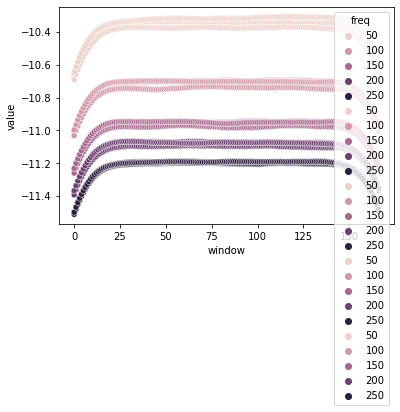

In [11]:
# # Pivot by window number
# means_longer = pd.melt(means, id_vars=['condition', 'freq'], var_name = 'window')

# # Subset by condition
# means_50 = means_longer[means_longer['condition'] == 50]
# means_100 = means_longer[means_longer['condition'] == 100]
# means_150 = means_longer[means_longer['condition'] == 150]
# means_200 = means_longer[means_longer['condition'] == 200]
# means_250 = means_longer[means_longer['condition'] == 250]

# # Plot
# sns.scatterplot(x='window', y='value', hue='freq', data=means_50) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_100) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_150) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_200) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_250) 

In [12]:
means_150

,condition,freq,window,value
10,150,50,0,-10.659503
11,150,100,0,-11.007067
12,150,150,0,-11.240793
13,150,200,0,-11.370743
14,150,250,0,-11.501345
...,...,...,...,...
4160,150,50,166,-10.632918
4161,150,100,166,-10.979348
4162,150,150,166,-11.208427
4163,150,200,166,-11.350860
